# Social DistilBERT Model Using Merged Data Experiment 1.1 with unigrams

In [5]:
import ktrain
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from ktrain import text
import random
import warnings
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

## 1. Loading the data and quick exploratory data analysis

In [2]:
merged_social_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Social_sentence_level_batch_1_jaccard.csv", encoding='utf-8')

# Shuffle the merged dataset
merged_social_df = shuffle(merged_social_df, random_state=seed)

# Vectorize text data to get unigram features
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words='english')
X_unigrams = vectorizer.fit_transform(merged_social_df['sentence']).toarray()

# Convert to DataFrame for easier manipulation
df_unigrams = pd.DataFrame(X_unigrams, columns=vectorizer.get_feature_names_out())

# Train-test split 
training_df, test_df = train_test_split(merged_social_df, test_size=0.2, random_state=18, stratify=merged_social_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (1300, 3) 
Test dataset shape: (325, 3)
Positive labels present in the dataset : 148  out of 1300 or 11.384615384615385%
Positive labels present in the test dataset : 37  out of 325 or 11.384615384615385%


## 2. Experimental Design

In [23]:
MAXLEN = 150

In [24]:
X = training_df['sentence']
y = training_df['label']

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 18, stratify=y)

In [26]:
model_name = 'distilbert-base-uncased'

In [27]:
distillbert_transformer = text.Transformer(model_name, maxlen=MAXLEN, class_names=[0,1])
training_set = distillbert_transformer.preprocess_train(X_train.tolist(), y_train.tolist())
validation_set = distillbert_transformer.preprocess_test(X_test.tolist(), y_test.tolist())
distillbert_base_model = distillbert_transformer.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 21
	95percentile : 39
	99percentile : 53


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 20
	95percentile : 42
	99percentile : 55


In [78]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define classes and class labels
classes = np.array([0, 1])
class_labels = list(training_df.label)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=class_labels)

# Print class weights
print(class_weights)

class_weights = {0:0.56103896,1:4.59574468}


[0.56423611 4.39189189]


In [119]:
distillbert_learner = ktrain.get_learner(distillbert_base_model, train_data=training_set, val_data=validation_set, batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
173/173 [==============================] - 37s 163ms/step - loss: 0.2723 - accuracy: 0.9586
Epoch 2/1024
173/173 [==============================] - 32s 157ms/step - loss: 0.2323 - accuracy: 0.9565
Epoch 3/1024
173/173 [==============================] - 27s 155ms/step - loss: 0.1621 - accuracy: 0.9487
Epoch 4/1024
173/173 [==============================] - 27s 155ms/step - loss: 0.2800 - accuracy: 0.8443
Epoch 5/1024
173/173 [==============================] - 13s 72ms/step - loss: 0.6411 - accuracy: 0.6955


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 5.63E-06
	Min numerical gradient (purple): 2.27E-06
	Min loss divided by 10 (omitted from plot): 6.07E-06


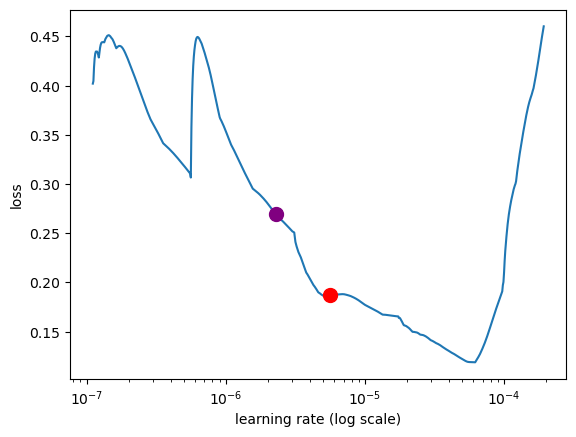

In [40]:
# distillbert_learner.lr_find(class_weight=class_weights, suggest=True, show_plot=True, verbose=1)

In [120]:
distillbert_learner.autofit(2.27E-06, early_stopping=4)
# distillbert_learner.autofit(2.27E-06, early_stopping=4, class_weight=class_weights)
# distillbert_learner.set_weight_decay(0.001)
# distillbert_learner.autofit(2.27E-06, early_stopping=4, class_weight=class_weights)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2.27e-06...
Epoch 1/1024
174/174 [==============================] - 102s 421ms/step - loss: 0.0731 - accuracy: 0.9702 - val_loss: 0.4209 - val_accuracy: 0.8769
Epoch 2/1024
174/174 [==============================] - 43s 245ms/step - loss: 0.0528 - accuracy: 0.9760 - val_loss: 0.4182 - val_accuracy: 0.8769
Epoch 3/1024
174/174 [==============================] - 44s 249ms/step - loss: 0.0541 - accuracy: 0.9692 - val_loss: 0.4422 - val_accuracy: 0.8769
Epoch 4/1024
174/174 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9721
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 1.135e-06 (if not early_stopping).
174/174 [==============================] - 41s 233ms/step - loss: 0.0519 - accuracy: 0.9721 - val_loss: 0.4231 - val_accuracy: 0.8731
Epoch 5/1024
174/174 [==============================] - 42s 235ms/step - loss: 0.0474 - accurac

In [121]:
distillbert_learner.validate(class_names=distillbert_transformer.get_classes())

9/9 [==============================] - 3s 334ms/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       230
           1       0.44      0.23      0.30        30

    accuracy                           0.88       260
   macro avg       0.67      0.60      0.62       260
weighted avg       0.85      0.88      0.86       260



array([[221,   9],
       [ 23,   7]])

In [122]:
distillbert_learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_79 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
distillbert_predictor = ktrain.get_predictor(distillbert_learner.model, preproc=distillbert_transformer)

In [124]:
distillbert_test_data = test_df['sentence'].tolist()
distillbert_test_label = test_df['label'].tolist()

In [125]:
y_pred_distillbert = distillbert_predictor.predict(distillbert_test_data)

In [126]:
y_pred_distillbert = [int(x) for x in y_pred_distillbert]

In [127]:
tn, fp, fn, tp = confusion_matrix(distillbert_test_label, y_pred_distillbert).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))

True Negative: 270, False Positive: 18, False Negative: 24, True Positive: 13


In [128]:
print('  Classification Report:\n',classification_report(distillbert_test_label,y_pred_distillbert),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       288
           1       0.42      0.35      0.38        37

    accuracy                           0.87       325
   macro avg       0.67      0.64      0.66       325
weighted avg       0.86      0.87      0.87       325
 



In [129]:
# distillbert_predictor.save('../../model/first_generation_distilbert_base_uncased_model_10102020') # 256 MB

In [130]:
print("AUC roc score for distillbert model: ", roc_auc_score(distillbert_test_label,y_pred_distillbert))

AUC roc score for distillbert model:  0.6444256756756757
